# mlbotの初心者向けチュートリアル(BitFlyer版)

richmanbtcさんのmlbotの初心者向けチュートリアルをBitFlyer向けに記載したものです。

## 必要なライブラリのインポート

以下のコードでは必要なライブラリをインポートしています。

In [78]:
import math

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib
import datetime,time,requests
from datetime import timedelta

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [79]:
import warnings
warnings.filterwarnings('ignore')

# from pyfeatures import features,calc_features
%load_ext autoreload
%autoreload 2
from pyfeatures import features,calc_features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## データを用意
BitFlyerのAPI(チャート用)を利用して1分足のOHLCVを取得します。

In [80]:
# headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}

# start_datetime = datetime.datetime.strptime("2022-05-11 00:00:00", "%Y-%m-%d %H:%M:%S")
# end_datetime = datetime.datetime.strptime("2018-01-07 00:00:00", "%Y-%m-%d %H:%M:%S")
# target_coin = "FX_BTC_JPY"


# ohlc_list=[]
# while start_datetime > end_datetime:
#     unixtime = start_datetime.timestamp() * 1000
#     response = requests.get( f"https://lightchart.bitflyer.com/api/ohlc?symbol={target_coin}&period=m&before={unixtime}", headers= headers).json()
#     ohlc_list.extend(response)
#     start_datetime -= timedelta(minutes=720)
#     time.sleep(1)


# df_1m = pd.DataFrame(ohlc_list,columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume','volume_buy_sum','volume_sell_sum','volume_buy','volume_sell'])
# df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"]/1000,unit='s', utc=True)
# df_1m.set_index("timestamp",inplace=True)
# df_1m.sort_index(inplace=True)
# display(df_1m)

# df_1m.to_pickle('df_bf_fx_ohlcv_1m.pkl')

1分足のOHLCVを15分足に変換します。

In [81]:
df_1m = pd.read_pickle('df_bf_fx_ohlcv_1m.pkl')
# df_1m = df_1m[df_1m.index.year >= 2020]
rule = "15T"
df = pd.DataFrame()
df["op"] = df_1m["op"].resample(rule).first()
df["hi"] = df_1m["hi"].resample(rule).max()
df["lo"] = df_1m["lo"].resample(rule).min()
df["cl"] = df_1m["cl"].resample(rule).last()
df["volume"] = df_1m["volume"].resample(rule).sum()

display(df)
df.to_pickle('df_bf_fx_ohlcv.pkl')

,op,hi,lo,cl,volume
timestamp,,,,,
2018-01-06 12:00:00+00:00,2233853.0,2241700.0,2231111.0,2233000.0,729.759980
2018-01-06 12:15:00+00:00,2233000.0,2233458.0,2220132.0,2224899.0,940.678245
2018-01-06 12:30:00+00:00,2224899.0,2231682.0,2222000.0,2226737.0,409.952456
2018-01-06 12:45:00+00:00,2226737.0,2226739.0,2201400.0,2210000.0,1481.500831
2018-01-06 13:00:00+00:00,2210000.0,2228400.0,2205858.0,2224500.0,1050.309835
...,...,...,...,...,...
2022-05-09 23:00:00+00:00,4130824.0,4146500.0,4104753.0,4105628.0,92.002445
2022-05-09 23:15:00+00:00,4107267.0,4110174.0,4054999.0,4062239.0,221.617523
2022-05-09 23:30:00+00:00,4062907.0,4086150.0,4002450.0,4017833.0,211.950218


## maker手数料カラムを追加
0円とする。SFDの手数料の考慮は省略。  
https://bitflyer.com/ja-jp/commission

In [82]:
df = pd.read_pickle('df_bf_fx_ohlcv.pkl')
df['fee'] = 0.0
display(df)
df.to_pickle('df_bf_fx_ohlcv_with_fee.pkl')

,op,hi,lo,cl,volume,fee
timestamp,,,,,,
2018-01-06 12:00:00+00:00,2233853.0,2241700.0,2231111.0,2233000.0,729.759980,0.0
2018-01-06 12:15:00+00:00,2233000.0,2233458.0,2220132.0,2224899.0,940.678245,0.0
2018-01-06 12:30:00+00:00,2224899.0,2231682.0,2222000.0,2226737.0,409.952456,0.0
2018-01-06 12:45:00+00:00,2226737.0,2226739.0,2201400.0,2210000.0,1481.500831,0.0
2018-01-06 13:00:00+00:00,2210000.0,2228400.0,2205858.0,2224500.0,1050.309835,0.0
...,...,...,...,...,...,...
2022-05-09 23:00:00+00:00,4130824.0,4146500.0,4104753.0,4105628.0,92.002445,0.0
2022-05-09 23:15:00+00:00,4107267.0,4110174.0,4054999.0,4062239.0,221.617523,0.0
2022-05-09 23:30:00+00:00,4062907.0,4086150.0,4002450.0,4017833.0,211.950218,0.0


## 特徴量エンジニアリング

## 学習に使う特徴量の定義

## 目的変数の計算

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


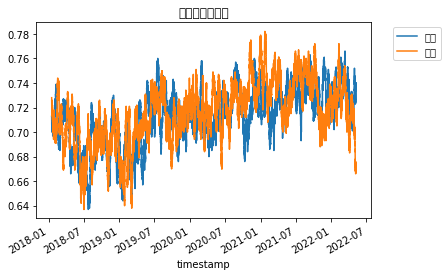

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


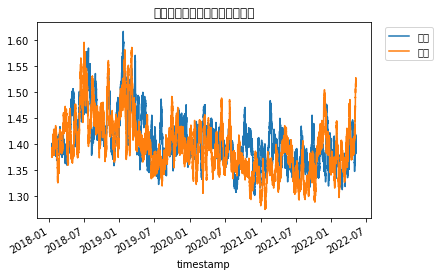

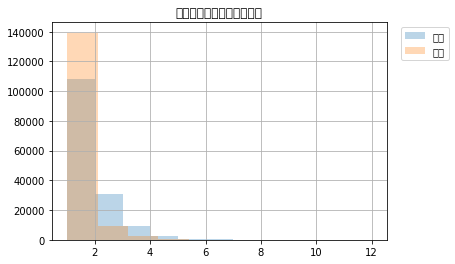

毎時刻、この執行方法でトレードした場合の累積リターン


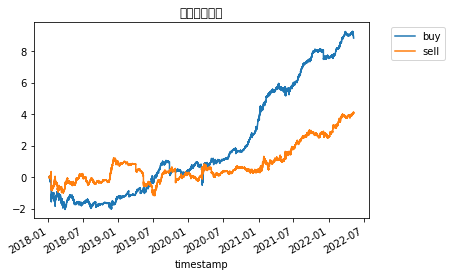

108070
108544


In [83]:
df = pd.read_pickle('df_bf_fx_ohlcv_with_fee.pkl')
df = df.dropna()
df = calc_features(df)
df.to_pickle('df_bf_fx_features.pkl')

@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_bf_fx_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
# limit_price_dist = df['ATR'] * 0.5
# limit_price_dist = df['ATR'] * 0.1
# limit_price_dist = df['ATR'] * 0.1557
limit_price_dist = df['ATR'] * 0.2
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='買い')
df['sell_executed'].rolling(1000).mean().plot(label='売り')
plt.title('約定確率の推移')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='買い')
df['sell_fet'].rolling(1000).mean().plot(label='売り')
plt.title('エグジットまでの平均時間推移')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='買い')
df['sell_fet'].hist(alpha=0.3, label='売り')
plt.title('エグジットまでの時間分布')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()
print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='buy')
df['y_sell'].cumsum().plot(label='sell')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# df = df[df['y_buy']!= 0]
# print('毎時刻、この執行方法でトレードした場合の累積リターン')
# df['y_buy'].cumsum().plot(label='買い')
# df['y_sell'].cumsum().plot(label='売り')
# plt.title('累積リターン')
# plt.legend(bbox_to_anchor=(1.05, 1))
# plt.show()
df

print(len(df[df['y_buy']!=0]))
print(len(df[df['y_sell']!=0]))

df.to_pickle('df_bf_fx_y.pkl')

## モデルの学習とOOS予測値計算

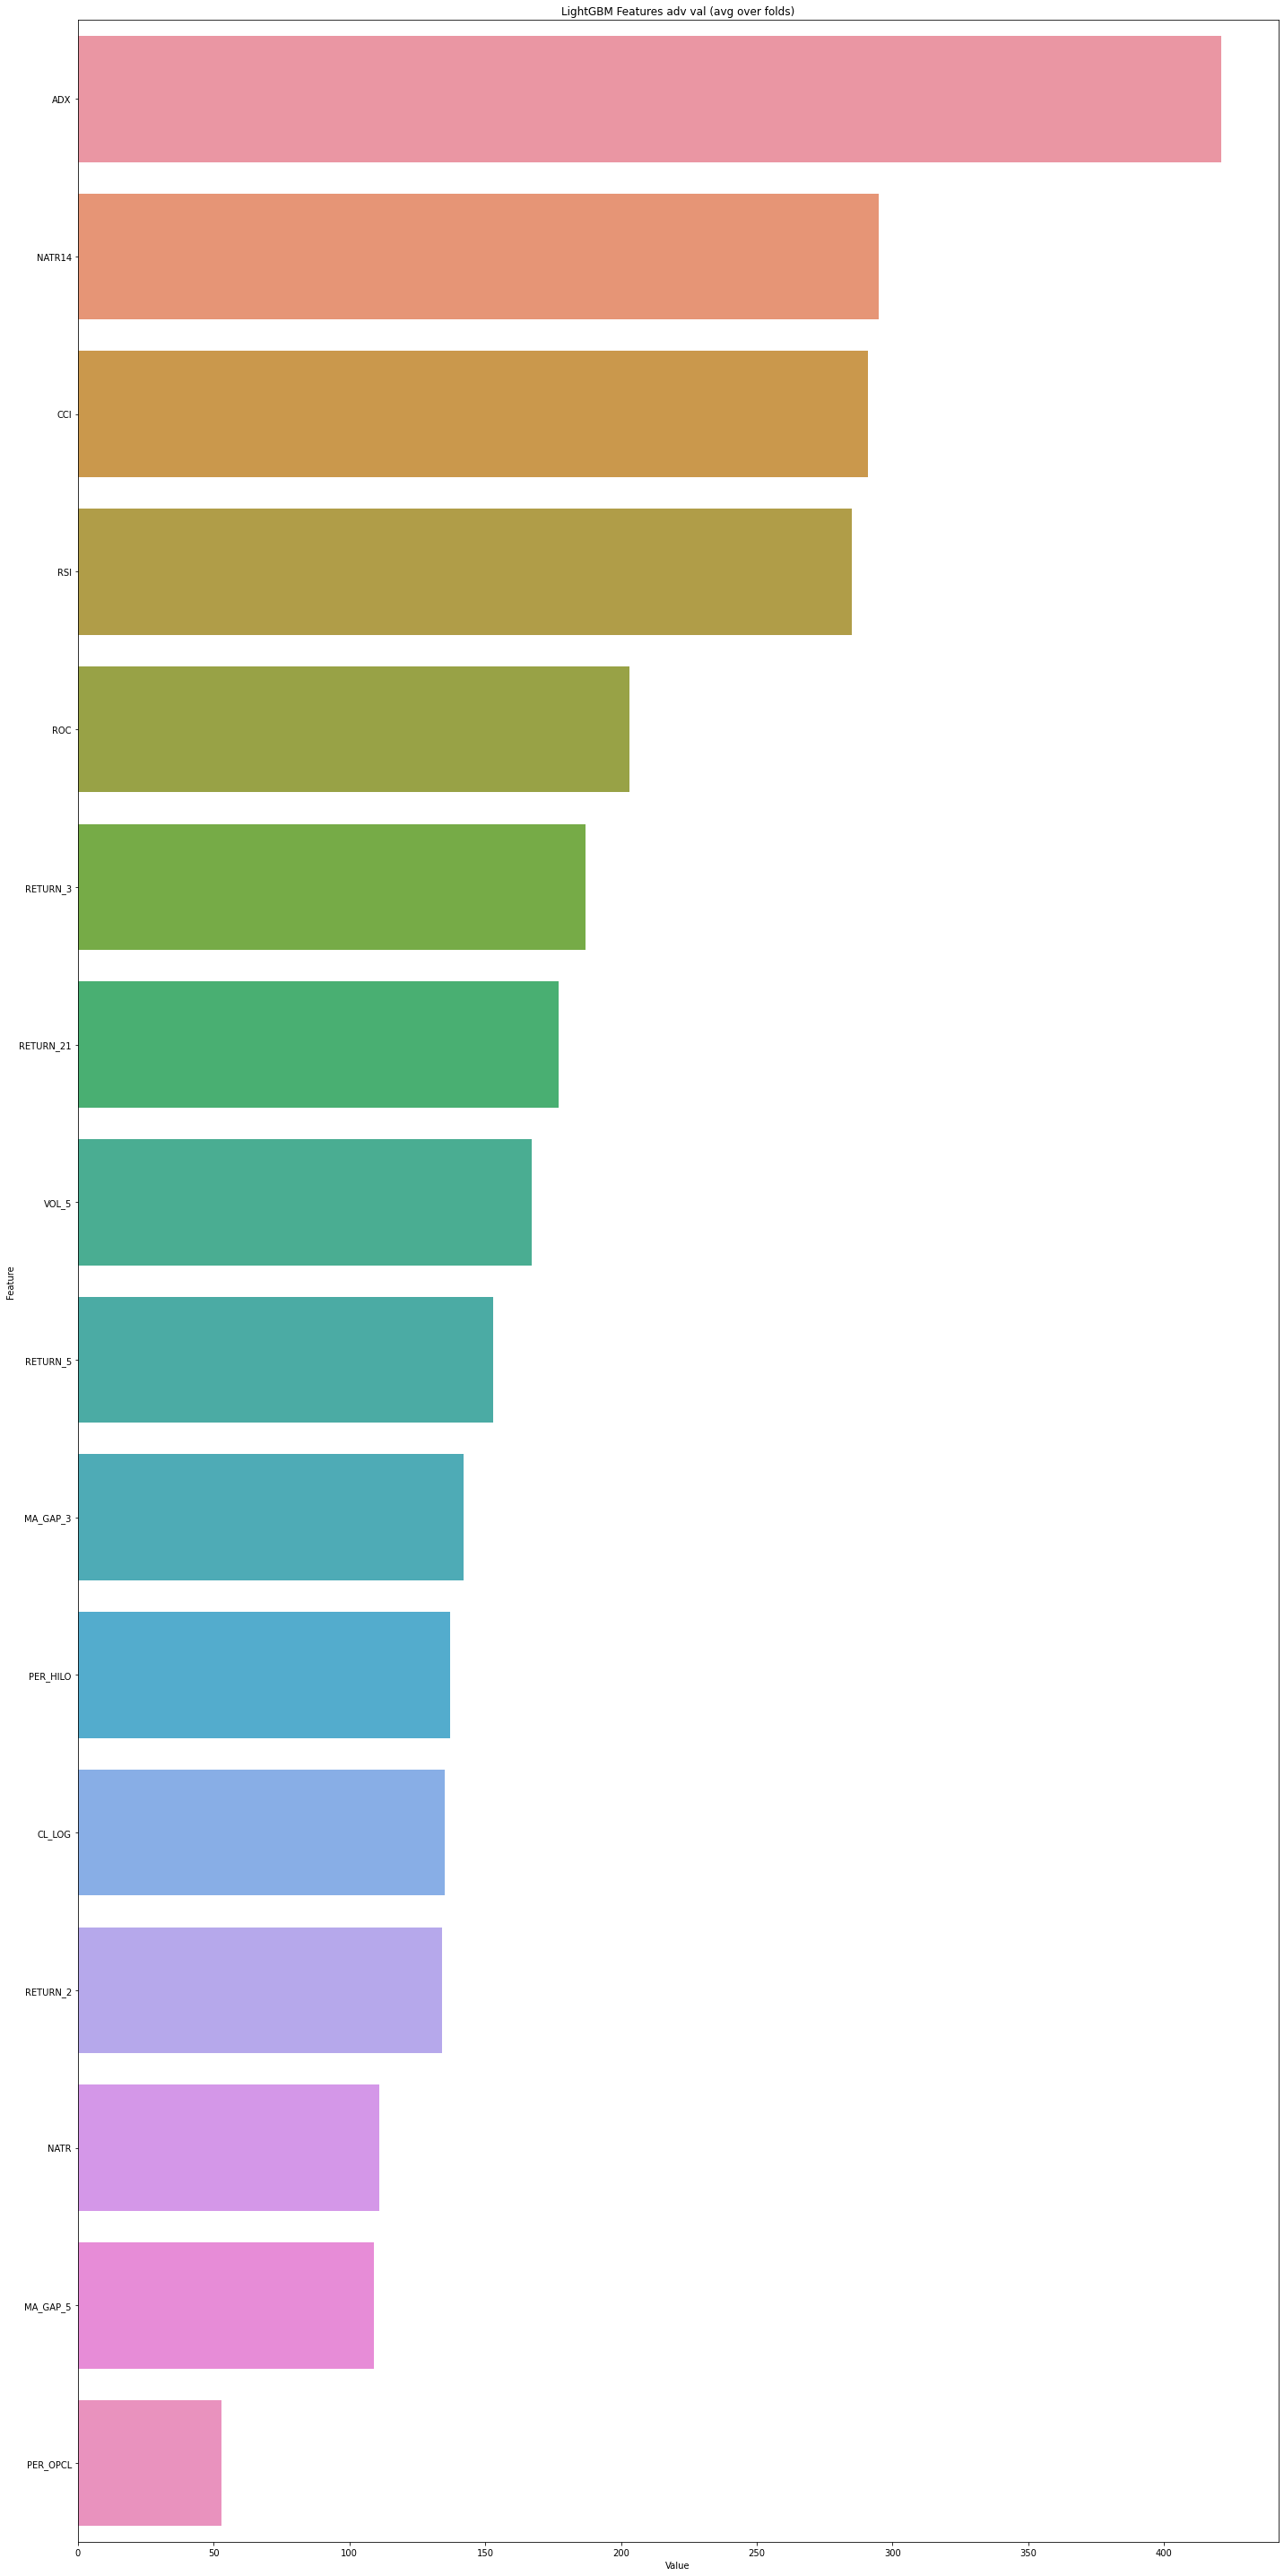

スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)
scores [0.12923497 0.12676709]
score mean, std 0.1280010292168664 0.0012339362559669054


In [84]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1)

model.fit(df[features], df['y_buy'])

lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()

print('スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)')
cv = KFold(n_splits=2, shuffle=True, random_state=0)
scores = cross_val_score(model, df[features], np.arange(df.shape[0]), scoring='r2', cv=cv)
print('scores', scores)
print('score mean, std', np.mean(scores), np.std(scores))

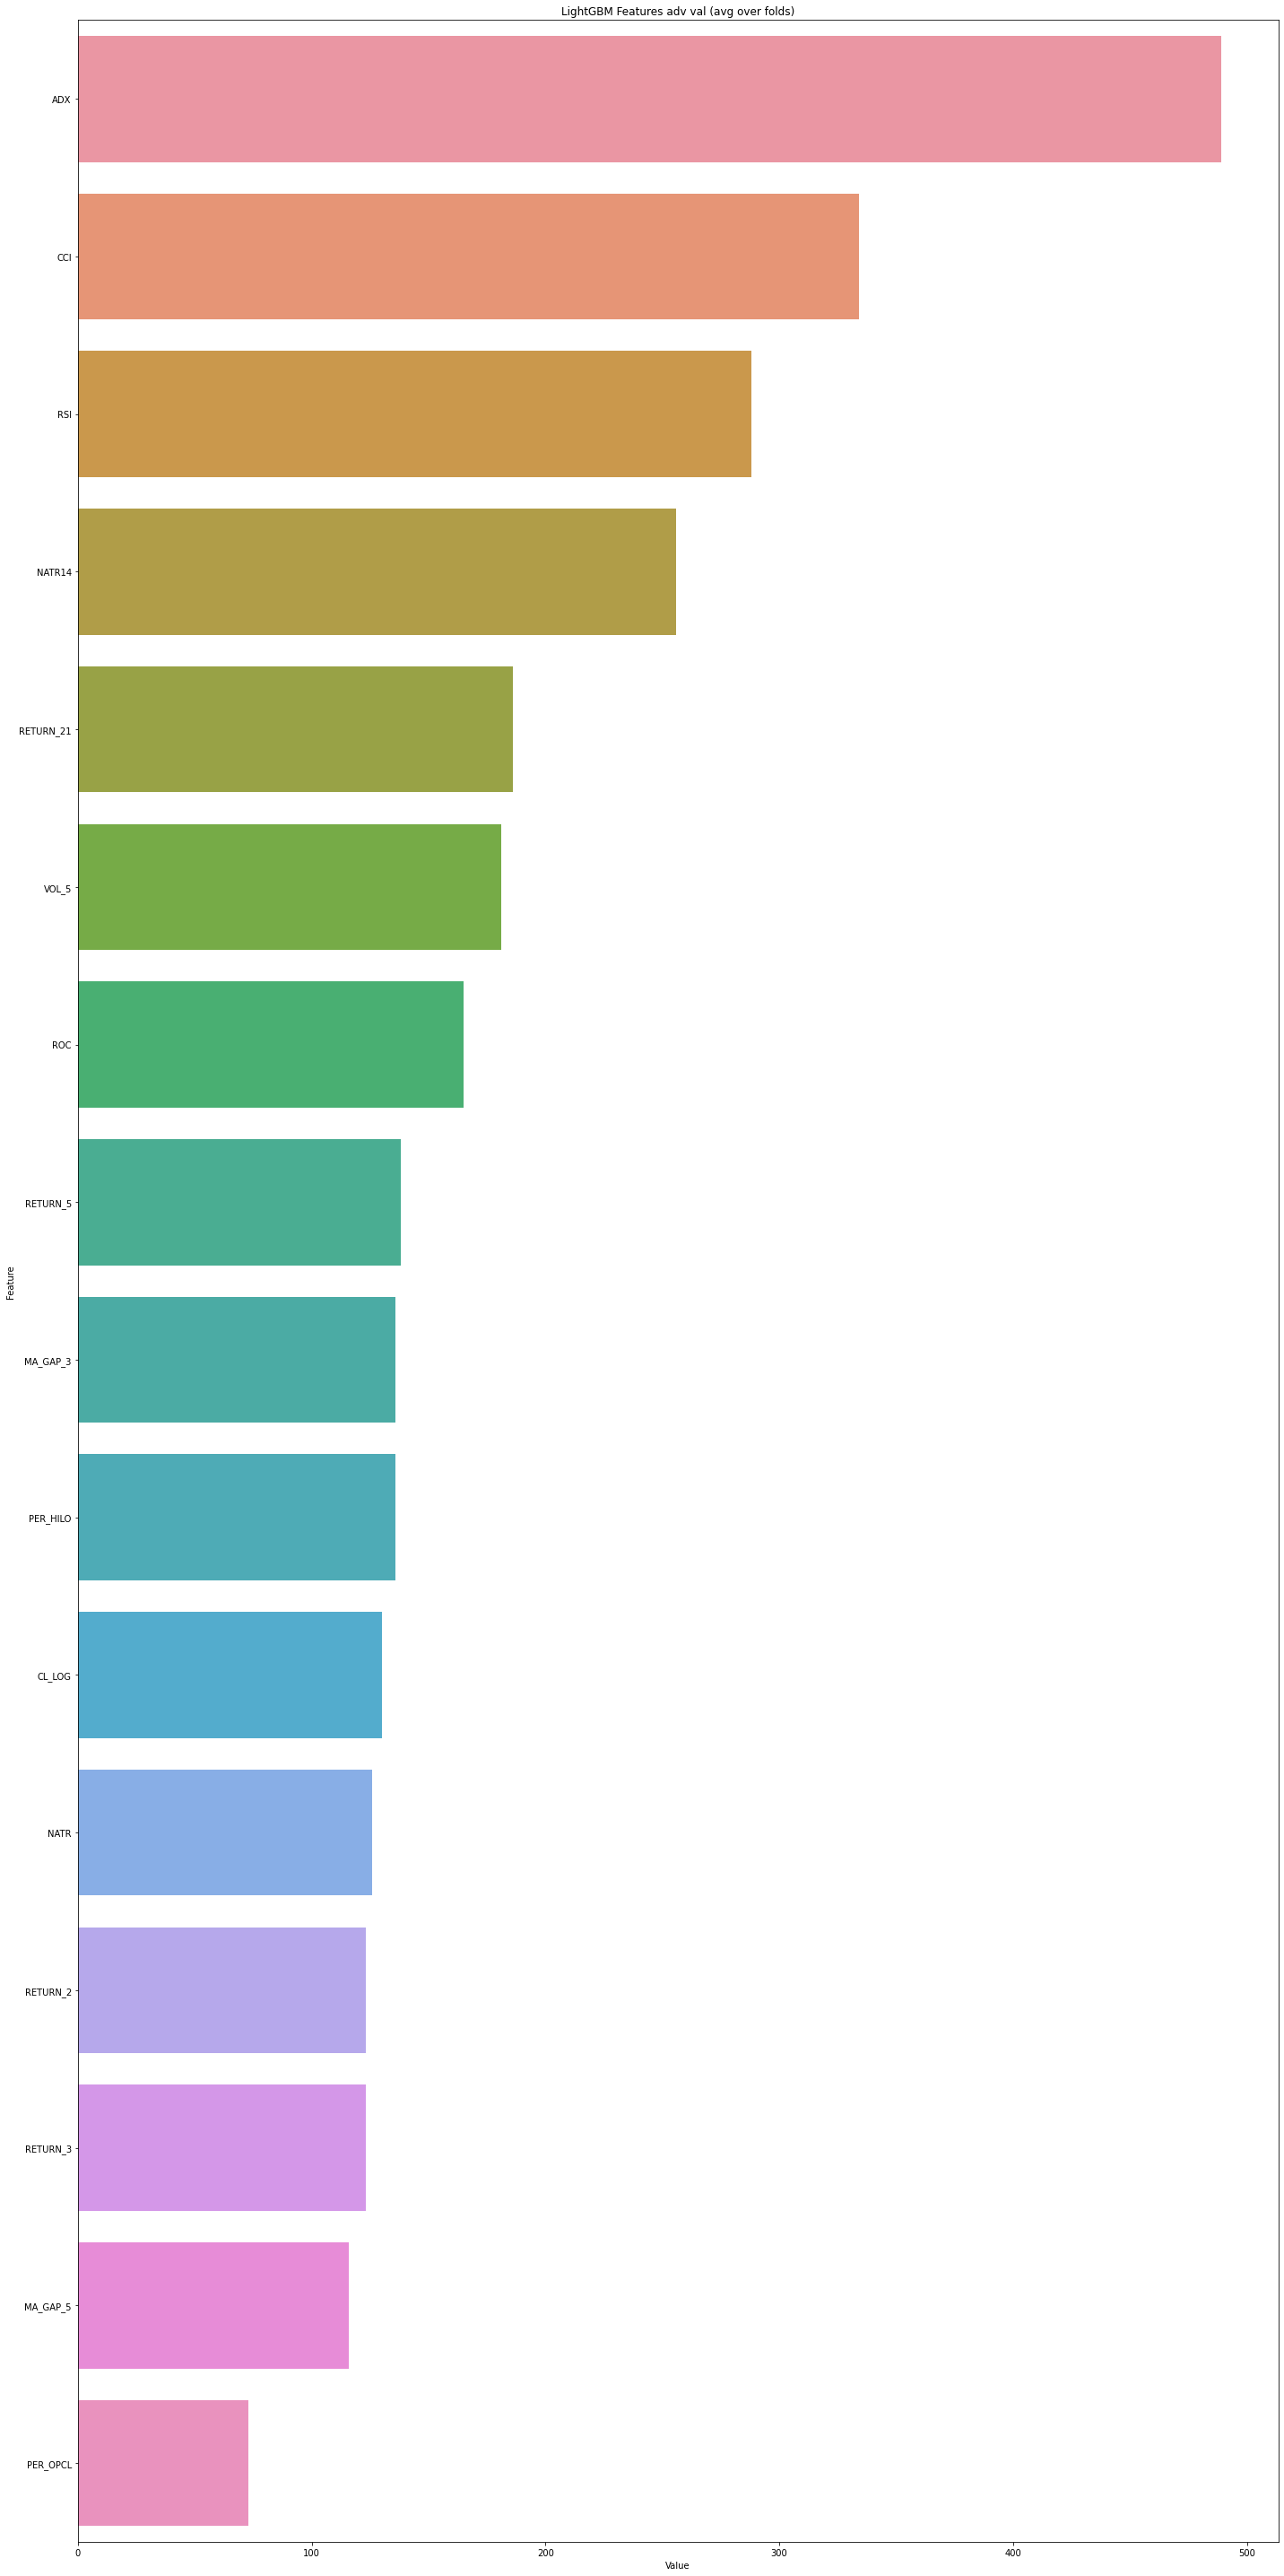

スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)
scores [0.12923497 0.12676709]
score mean, std 0.1280010292168664 0.0012339362559669054


In [85]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1)

model.fit(df[features], df['y_sell'])

lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()

print('スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)')
cv = KFold(n_splits=2, shuffle=True, random_state=0)
scores = cross_val_score(model, df[features], np.arange(df.shape[0]), scoring='r2', cv=cv)
print('scores', scores)
print('score mean, std', np.mean(scores), np.std(scores))

In [86]:
# from pycaret.regression import *
# import copy
# df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df.dropna()
# df = df[df.index.year <= 2021]
# features_ybuy = copy.deepcopy(features)
# features_ybuy.append('y_buy')
# exp1 = setup(df[features_ybuy], target = 'y_buy',fold_shuffle=True,)
# model_pycaret = create_model('lightgbm')
# tuned_model = tune_model(model_pycaret, n_iter = 50, optimize = 'mae')
# tuned_model.get_params

In [87]:
import sklearn
print(sklearn.__version__)
!pip show pycaret


1.0.2
Name: pycaret
Version: 2.2.2
Summary: PyCaret - An open source, low-code machine learning library in Python.
Home-page: https://github.com/pycaret/pycaret
Author: Moez Ali
Author-email: moez.ali@queensu.ca
License: MIT
Location: c:\users\cheap\anaconda3\envs\bitflyer_bot\lib\site-packages
Requires: nltk, wordcloud, yellowbrick, plotly, catboost, pyLDAvis, mlflow, textblob, pandas, spacy, xgboost, umap-learn, cufflinks, scikit-plot, kmodes, matplotlib, numpy, joblib, IPython, mlxtend, seaborn, pandas-profiling, scikit-learn, gensim, ipywidgets, pyod, lightgbm, imbalanced-learn
Required-by: 


In [88]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()
df

,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,BBANDS1_upperband,...,buy_fep,buy_fet,sell_fep,sell_fet,buy_executed,sell_executed,y_buy,y_sell,buy_cost,sell_cost
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-07 10:15:00+00:00,2300145.0,2304572.0,2296992.0,2302299.0,401.039434,0.0,9552.032682,-2041.40,-2.314417e+06,3755.316341,...,2300096.0,1.0,2304502.0,1.0,1.0,1.0,0.000503,0.003270,-0.000957,-0.000957
2018-01-07 10:30:00+00:00,2302299.0,2305000.0,2298190.0,2299109.0,380.134787,0.0,8818.992186,-2744.85,-2.315904e+06,3037.071093,...,2296966.0,1.0,2301252.0,1.0,1.0,1.0,0.002419,0.001281,-0.000932,-0.000932
2018-01-07 10:45:00+00:00,2299109.0,2303500.0,2295150.0,2300413.0,450.116331,0.0,10056.365212,-831.85,-2.311045e+06,4612.257606,...,2298303.0,1.0,2302523.0,1.0,1.0,1.0,0.003803,-0.000110,-0.000917,-0.000917
2018-01-07 11:00:00+00:00,2300413.0,2310000.0,2297825.0,2304910.0,557.968401,0.0,5925.603724,-5248.75,-2.320336e+06,338.426862,...,2302777.0,1.0,2307043.0,1.0,1.0,1.0,0.000632,0.003381,-0.000925,-0.000925
2018-01-07 11:15:00+00:00,2304910.0,2309825.0,2297810.0,2302080.0,762.911445,0.0,6314.946760,-4953.05,-2.320039e+06,680.948380,...,2299243.0,2.0,2304232.0,1.0,0.0,1.0,0.000000,0.002165,0.000000,-0.000935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09 22:15:00+00:00,4114437.0,4136187.0,4106540.0,4109705.0,122.073854,0.0,88882.200336,-10016.10,-4.230278e+06,39433.050168,...,4129823.0,2.0,4122738.0,1.0,0.0,1.0,0.000000,-0.001719,0.000000,-0.003171
2022-05-09 22:30:00+00:00,4109701.0,4154105.0,4109701.0,4142560.0,100.949418,0.0,67738.967070,-23492.30,-4.246627e+06,22123.333535,...,4129823.0,1.0,4155297.0,1.0,1.0,1.0,0.003330,0.008799,-0.003075,-0.003075
2022-05-09 22:45:00+00:00,4142751.0,4168300.0,4126769.0,4131154.0,110.875348,0.0,52438.694182,-38951.00,-4.277875e+06,6743.847091,...,4118734.0,1.0,4143574.0,1.0,1.0,1.0,-0.010791,0.012085,-0.003006,-0.003006


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 

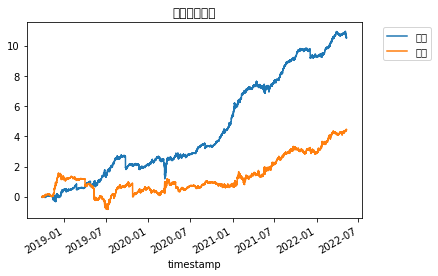

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


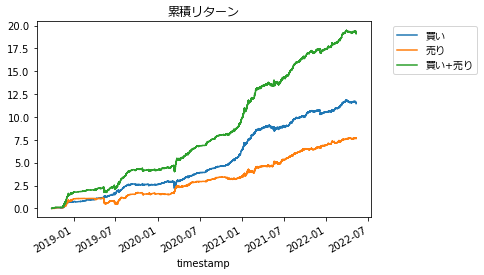

44703
30924


In [89]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()
# print(len(df))
# df = df[df['y_buy']!=0]
# print(len(df))

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
#model = lgb.LGBMRegressor(n_jobs=-1,extra_trees=True)
model = lgb.LGBMRegressor(n_jobs=-1,num_leaves=63,learning_rate=0.01,feature_fraction=0.8,bagging_freq=1,bagging_fraction=0.8,random_state=0,extra_trees=True)
# model = lgb.LGBMRegressor(
#                 class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
#                 importance_type='split', learning_rate=0.05, max_depth=-1,
#                 min_child_samples=26, min_child_weight=0.001, min_split_gain=0.7,
#                 n_estimators=290, n_jobs=-1, num_leaves=20, objective=None,
#                 random_state=8101, reg_alpha=10, reg_lambda=3, silent='warn',
#                 subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
#                 extra_trees=True
# )

# アンサンブル (コメントアウトを外して性能を比較してみてください)
model = BaggingRegressor(model, random_state=1, n_jobs=1)


# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
model.fit(df[features], df['y_buy'])
joblib.dump(model, './model/model_y_buy_bffx.xz', compress=True) 
model.fit(df[features], df['y_sell'])
joblib.dump(model, './model/model_y_sell_bffx.xz', compress=True)

# 通常のCV
# cv_indicies = list(KFold().split(df))
# ウォークフォワード法
cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df_buy_fit = df[df['y_buy'] != 0]
df_sell_fit = df[df['y_sell'] != 0]
df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df[df['y_buy']!=0]['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン',fontname="Meiryo")
plt.legend(bbox_to_anchor=(1.05, 1), prop={"family":"Meiryo"})
plt.show()

print(len(df[(df['y_pred_buy'] > 0) & (df['y_buy'] != 0)]))
print(len(df[(df['y_pred_sell'] > 0) & (df['y_sell'] != 0)]))

df.to_pickle('df_bf_fx_fit.pkl')

151628
毎時刻、この執行方法でトレードした場合の累積リターン


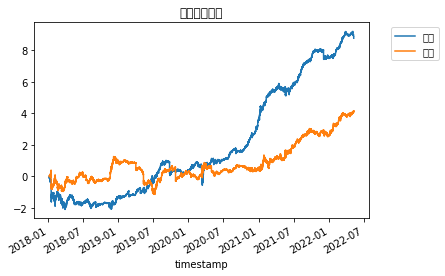

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


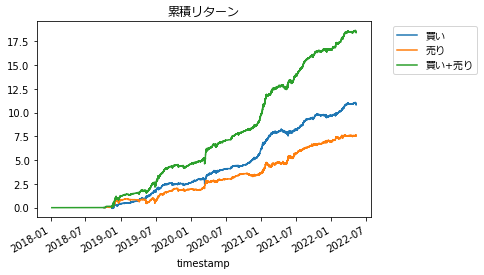

45689
38445


,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,BBANDS1_upperband,...,sell_fep,sell_fet,buy_executed,sell_executed,y_buy,y_sell,buy_cost,sell_cost,y_pred_buy,y_pred_sell
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-07 10:15:00+00:00,2300145.0,2304572.0,2296992.0,2302299.0,401.039434,0.0,9552.032682,-2041.40,-2.314417e+06,3755.316341,...,2304502.0,1.0,1.0,1.0,0.000503,0.003270,-0.000957,-0.000957,0.000000,0.000000
2018-01-07 10:30:00+00:00,2302299.0,2305000.0,2298190.0,2299109.0,380.134787,0.0,8818.992186,-2744.85,-2.315904e+06,3037.071093,...,2301252.0,1.0,1.0,1.0,0.002419,0.001281,-0.000932,-0.000932,0.000000,0.000000
2018-01-07 10:45:00+00:00,2299109.0,2303500.0,2295150.0,2300413.0,450.116331,0.0,10056.365212,-831.85,-2.311045e+06,4612.257606,...,2302523.0,1.0,1.0,1.0,0.003803,-0.000110,-0.000917,-0.000917,0.000000,0.000000
2018-01-07 11:00:00+00:00,2300413.0,2310000.0,2297825.0,2304910.0,557.968401,0.0,5925.603724,-5248.75,-2.320336e+06,338.426862,...,2307043.0,1.0,1.0,1.0,0.000632,0.003381,-0.000925,-0.000925,0.000000,0.000000
2018-01-07 11:15:00+00:00,2304910.0,2309825.0,2297810.0,2302080.0,762.911445,0.0,6314.946760,-4953.05,-2.320039e+06,680.948380,...,2304232.0,1.0,0.0,1.0,0.000000,0.002165,0.000000,-0.000935,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09 22:15:00+00:00,4114437.0,4136187.0,4106540.0,4109705.0,122.073854,0.0,88882.200336,-10016.10,-4.230278e+06,39433.050168,...,4122738.0,1.0,0.0,1.0,0.000000,-0.001719,0.000000,-0.003171,0.000000,0.001430
2022-05-09 22:30:00+00:00,4109701.0,4154105.0,4109701.0,4142560.0,100.949418,0.0,67738.967070,-23492.30,-4.246627e+06,22123.333535,...,4155297.0,1.0,1.0,1.0,0.003330,0.008799,-0.003075,-0.003075,0.000184,-0.000180
2022-05-09 22:45:00+00:00,4142751.0,4168300.0,4126769.0,4131154.0,110.875348,0.0,52438.694182,-38951.00,-4.277875e+06,6743.847091,...,4143574.0,1.0,1.0,1.0,-0.010791,0.012085,-0.003006,-0.003006,0.000492,0.000413


In [90]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()
# print(len(df))
df_buy = df[df['y_buy']!=0]
df_sell = df[df['y_sell']!=0]
print(len(df))

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1)
# model = lgb.LGBMRegressor(
#                 class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
#                 importance_type='split', learning_rate=0.05, max_depth=-1,
#                 min_child_samples=26, min_child_weight=0.001, min_split_gain=0.7,
#                 n_estimators=290, n_jobs=-1, num_leaves=20, objective=None,
#                 random_state=8101, reg_alpha=10, reg_lambda=3, silent='warn',
#                 subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
#                 extra_trees=True
# )

# アンサンブル (コメントアウトを外して性能を比較してみてください)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)


# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
# model.fit(df[features], df['y_buy'])
# joblib.dump(model, './model/model_y_buy_bffx.xz', compress=True) 
# model.fit(df[features], df['y_sell'])
# joblib.dump(model, './model/model_y_sell_bffx.xz', compress=True)

# 通常のCV
# cv_indicies = list(KFold().split(df))
# ウォークフォワード法
cv_indicies_buy = list(TimeSeriesSplit().split(df_buy))
cv_indicies_sell = list(TimeSeriesSplit().split(df_sell))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df_buy_fit = df[df['y_buy'] != 0]
df_sell_fit = df[df['y_sell'] != 0]
df_buy['y_pred_buy'] = my_cross_val_predict(model, df_buy[features].values, df_buy['y_buy'].values, cv=cv_indicies_buy)
df_sell['y_pred_sell'] = my_cross_val_predict(model, df_sell[features].values, df_sell['y_sell'].values, cv=cv_indicies_sell)

df = pd.merge(df, df_buy['y_pred_buy'], left_index=True, right_index=True, how='left')
df = pd.merge(df, df_sell['y_pred_sell'], left_index=True, right_index=True, how='left')
df['y_pred_buy'] = df['y_pred_buy'].fillna(0)
df['y_pred_sell'] = df['y_pred_sell'].fillna(0)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df_buy['y_buy'].cumsum().plot(label='買い')
df_sell['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン',fontname="Meiryo")
plt.legend(bbox_to_anchor=(1.05, 1), prop={"family":"Meiryo"})
plt.show()

print(len(df[(df['y_pred_buy'] > 0) & (df['y_buy'] != 0)]))
print(len(df[(df['y_pred_sell'] > 0) & (df['y_sell'] != 0)]))

# df.to_pickle('df_bf_fx_fit.pkl')
df

## バックテストと検定

1.0638602914794664


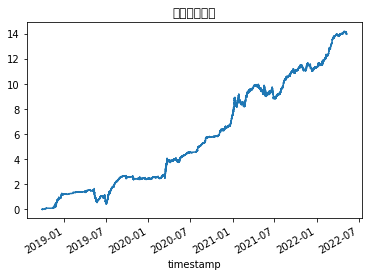

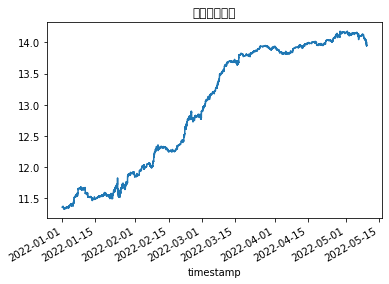

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


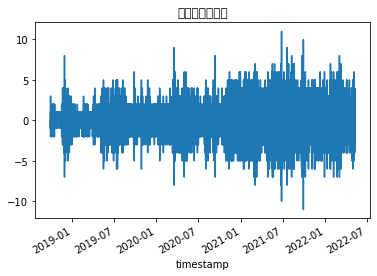

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


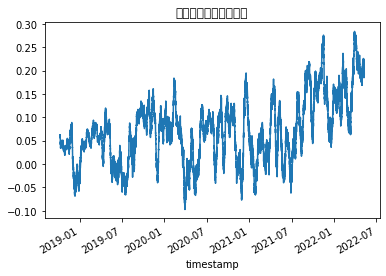

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


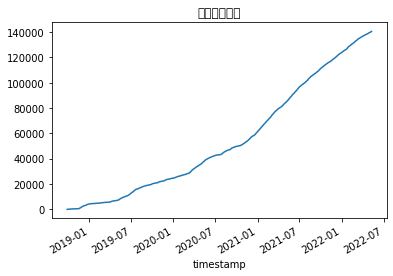

t検定
t値 6.79738218436096
p値 1.0700743882636147e-11
p平均法 n = 5
p平均 0.03482396041310056
エラー率 1.3337043814645338e-06


In [91]:
#@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None,
              date_time=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    old_ret = 0.0
    print_date = '2022-03-01 00:00:00'
    print_ret = 0.0

    for i in range(n):
        prev_pos = pos

        # exit
        if buy_cost[i]:
        #if sell_entry[i] < 0 and buy_cost[i]:
        #if buy_entry[i] < 0 and buy_cost[i]:
            #vol = np.minimum(1.0, 1 - prev_pos) * (buy_entry[i] > 0)
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
        #if buy_entry[i] < 0 and sell_cost[i]:
        #if sell_entry[i] < 0 and sell_cost[i]:
            #vol = np.minimum(1.0, prev_pos + 1) * (sell_entry[i] > 0)
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] > 0 and buy_cost[i]:
        #if buy_entry[i] > 0 and buy_cost[i] and buy_entry[i] >= sell_entry[i]:
            vol = np.minimum(2.0, 1 - prev_pos) * (buy_entry[i] > 0)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] > 0 and sell_cost[i]:
            vol = np.minimum(2.0, prev_pos + 1) * (sell_entry[i] > 0)
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos

        if date_time[i] > print_date:
            print_ret += (ret - old_ret)
        old_ret = ret
            

    print(print_ret)
    return y, poss

df = pd.read_pickle('df_bf_fx_fit.pkl')

# バックテストで累積リターンと、ポジションを計算
df_index = df
df_index['datetime'] = pd.to_datetime(df_index.index)
df_index['datetime'] = df_index['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

df['cum_ret'], df['poss'] = backtest(
    cl=df['cl'].values,
    # buy_entry=df['y_pred_buy'].values > 0,
    # sell_entry=df['y_pred_sell'].values > 0,
    buy_entry=df['y_pred_buy'].values,
    sell_entry=df['y_pred_sell'].values,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
    date_time=df_index['datetime'].values,
)


df['cum_ret'].plot()
plt.title('累積リターン')
plt.show()

df[df.index.year == 2022]['cum_ret'].plot()
plt.title('累積リターン')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df['poss'].plot()
plt.title('ポジション推移')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df['poss'].rolling(1000).mean().plot()
plt.title('ポジション平均の推移')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('取引量の累積')
plt.show()

print('t検定')
x = df['cum_ret'].diff(1).dropna()
t, p = ttest_1samp(x, 0)
print('t値 {}'.format(t))
print('p値 {}'.format(p))

# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))


## 実運用

In [92]:
# 最大ポジションサイズと月次利益の見積もり例
amount_per_day_jpy = 1000.0 * 10000 * 10000 # 1日の売買代金 1000億円
order_interval_min = 15.0 # 15分間隔で発注
monthly_return = 0.5 # 月次利益率 50%
my_order_ratio = 0.01 # 自分のボットの売買代金割合 1%

max_position_size = amount_per_day_jpy / (24 * 60) * order_interval_min * my_order_ratio
monthly_profit = max_position_size * monthly_return
print('最大ポジションサイズ {}円'.format(max_position_size))
print('月次利益 {}円'.format(monthly_profit))

最大ポジションサイズ 10416666.666666668円
月次利益 5208333.333333334円


##　売買判定 

BitFlyerが用意しているAPIからOHLCVを取得しモデルを利用して売買判定を出力します。
買い予想の数値(y_pred_buy)が0以上であれば買い、売り予想の数値(y_pred_sell)が0以上であれば売りと判断しています。
このためポジションの出力では買い予想の数値(y_pred_buy)のみが0以上の時に買い、売り予想の数値(y_pred_sell)のみが0以上の時に売りと判断しています。

In [93]:
#OHLCV取得
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}
unixtime = datetime.datetime.now().timestamp() * 1000
target_coin = "FX_BTC_JPY"
ohlc_list=[]

#1000本以上の1分足を取得
while len(ohlc_list) < 1000:
    response = requests.get( f"https://lightchart.bitflyer.com/api/ohlc?symbol={target_coin}&period=m&before={unixtime}", headers= headers).json()
    ohlc_list.extend(response)
    current_after = datetime.datetime.fromtimestamp(response[-1][0]/1000)
    next_before = current_after - timedelta(minutes=1)
    unixtime = int(next_before.timestamp() * 1000)
    time.sleep(1)

df_1m = pd.DataFrame(ohlc_list,columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume','volume_buy_sum','volume_sell_sum','volume_buy','volume_sell'])
df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"]/1000,unit='s', utc=True)
df_1m.set_index("timestamp",inplace=True)
df_1m.sort_index(inplace=True)

#15分足に変換
df = pd.DataFrame()
rule = "15T"
df["op"] = df_1m["op"].resample(rule).first()
df["hi"] = df_1m["hi"].resample(rule).max()
df["lo"] = df_1m["lo"].resample(rule).min()
df["cl"] = df_1m["cl"].resample(rule).last()
df["volume"] = df_1m["volume"].resample(rule).sum()

#特徴量の計算
df_features = calc_features(df)

#モデルの読み込み
model_y_buy = joblib.load('./model/model_y_buy_bffx.xz')
model_y_sell = joblib.load('./model/model_y_sell_bffx.xz')

#推論
df_features["predict_y_buy"] = model_y_buy.predict(df_features[features])
df_features["predict_y_sell"] = model_y_sell.predict(df_features[features])

#ポジションの判定

#買いポジションの判定
def calc_position_buy(x):
    buy = x["predict_y_buy"]
    if buy > 0:
        return "buy"
    else:
        return "none"
    
#売りポジションの判定
def calc_position_sell(x):
    buy = x["predict_y_sell"]
    if buy > 0:
        return "sell"
    else:
        return "none"

df_features["position_buy"] = df_features.apply(calc_position_buy,axis=1)
df_features["position_sell"] = df_features.apply(calc_position_sell,axis=1)

display(df_features)

position_buy = df_features["position_buy"].iloc[-1]
position_sell = df_features["position_sell"].iloc[-1]

if position_buy == "buy" and position_sell == "none":
    print("Buy Bitcoin")
elif position_sell == "sell" and position_buy == "none":
    print("Sell Bitcoin")
else:
    print("N/A")


,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,BBANDS1_upperband,BBANDS1_middleband,...,MA_GAP_89,hilo,PER_HILO,opcl,PER_OPCL,CL_LOG,predict_y_buy,predict_y_sell,position_buy,position_sell
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-05-10 00:00:00+00:00,4006840.0,4080000.0,3972625.0,4014449.0,398.443078,NaN,NaN,NaN,NaN,NaN,...,NaN,107375.0,0.026668,-7609.0,-0.001890,NaN,0.000005,0.000138,buy,sell
2022-05-10 00:15:00+00:00,4014656.0,4018796.0,3945965.0,3958786.0,316.810112,NaN,NaN,NaN,NaN,NaN,...,NaN,72831.0,0.018288,55870.0,0.014029,-0.013963,0.000016,0.000222,buy,sell
2022-05-10 00:30:00+00:00,3958684.0,4051465.0,3932545.0,4051465.0,376.642894,NaN,NaN,NaN,NaN,NaN,...,NaN,118920.0,0.029790,-92781.0,-0.023242,0.023141,0.000071,-0.000182,buy,none
2022-05-10 00:45:00+00:00,4050508.0,4097690.0,4022656.0,4045996.0,344.625611,NaN,NaN,NaN,NaN,NaN,...,NaN,75034.0,0.018480,4512.0,0.001111,-0.001351,0.000024,0.000110,buy,sell
2022-05-10 01:00:00+00:00,4045438.0,4100000.0,4043440.0,4086022.0,15.517754,NaN,NaN,NaN,NaN,NaN,...,NaN,56560.0,0.013891,-40584.0,-0.009967,0.009844,0.000266,0.000166,buy,sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-10 21:00:00+00:00,4097837.0,4118431.0,4075079.0,4098191.0,99.985799,110812.998211,45247.60,-4.117073e+06,78030.299105,45247.60,...,NaN,43352.0,0.010582,-354.0,-0.000086,0.000086,-0.000013,0.000152,none,sell
2022-05-10 21:15:00+00:00,4098630.0,4106541.0,4058660.0,4076837.0,77.692633,127536.253042,58181.05,-4.093775e+06,92858.651521,58181.05,...,NaN,47881.0,0.011728,21793.0,0.005338,-0.005224,0.000129,0.000140,buy,sell
2022-05-10 21:30:00+00:00,4076592.0,4085334.0,4023425.0,4047092.0,133.820457,162541.510848,83743.10,-4.049435e+06,123142.305424,83743.10,...,NaN,61909.0,0.015270,29500.0,0.007276,-0.007323,0.000343,0.000188,buy,sell


N/A


In [94]:
#初回だけ実行
#!pip install optuna

import optuna
optuna.logging.disable_default_handler()
import warnings
warnings.filterwarnings('ignore')


def calc_y(df,param):
    # 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
    pips = 0.01

    # ATRで指値距離を計算します
    limit_price_dist = df['ATR'] * param['atr']
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

    # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
    df['buy_price'] = df['cl'] - limit_price_dist
    df['sell_price'] = df['cl'] + limit_price_dist

    #df['buy_price'] = df['cl'] + df['BBANDS_lowerband'] 
    #df['sell_price'] = df['cl'] + limit_price_dist 

    # Force Entry Priceの計算
    df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
        entry_price=df['buy_price'].values,
        lo=df['lo'].values,
        pips=pips,
    )

    # calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
    df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
        entry_price=-df['sell_price'].values,
        lo=-df['hi'].values, # 売りのときは高値
        pips=pips,
    )
    df['sell_fep'] *= -1

    horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
    fee = df['fee'] # maker手数料

    # 指値が約定したかどうか (0, 1)
    df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
    df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

    # yを計算
    df['y_buy'] = np.where(
        df['buy_executed'],
        df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
        0
    )
    df['y_sell'] = np.where(
        df['sell_executed'],
        -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
        0
    )

    # バックテストで利用する取引コストを計算
    df['buy_cost'] = np.where(
        df['buy_executed'],
        df['buy_price'] / df['cl'] - 1 + fee,
        0
    )
    df['sell_cost'] = np.where(
        df['sell_executed'],
        -(df['sell_price'] / df['cl'] - 1) + fee,
        0
    )
    return df

df_features = pd.read_pickle('df_bf_fx_features.pkl')
df_features = df_features[df_features.index > pd.to_datetime('2022-05-01 00:00:00Z')]
def objective(trial):
    atr = trial.suggest_uniform('atr', 0.0, 2.0)
    param = {"atr":atr}
    df = calc_y(df_features,param)
    score = df['y_buy'].cumsum().iloc[-1] + df['y_sell'].cumsum().iloc[-1]
    print("atr:{} score{}".format(atr,score))
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
# プログラムが試行錯誤した結果最も良いパラメータを表示
print("best param: {}".format(study.best_params))
# 最も良いパラメータで実行したときの結果（返り値）を表示
print("best score: {}".format(study.best_value))

atr:0.303214884817004 score-0.23995404551659805
atr:1.1623252430764595 score-0.3584443093439653
atr:1.8547148379379497 score-0.18842116134154097
atr:1.8856261871679796 score-0.19570726322173304
atr:0.8911896084293061 score-0.12325729817211617
atr:0.1740340874285089 score0.0056015146050560904
atr:0.4039216039732574 score-0.07603948153591444
atr:0.9122447855372731 score-0.22178147271101145
atr:0.04345012514338942 score-0.040169251854058396
atr:0.929314678804954 score-0.036000414472329934
atr:1.4295402327131843 score-0.4236855637968263
atr:0.6195371386756925 score-0.22237863497117316
atr:1.3939524223426245 score-0.24475020988281493
atr:0.6402720547953293 score-0.19932885878867035
atr:0.08228579816067105 score0.052572772176591065
atr:0.00709217869584107 score-0.16710815961678938
atr:0.2943093587963186 score-0.2711272862344051
atr:0.5898623977511448 score-0.2287670238971472
atr:0.1794914975472955 score-0.11474438149328348
atr:0.442263100542035 score0.0366513880077155
atr:0.4827497195060688 